# Import Libraries

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [2]:
from choices import param_dict 
from utilities import deets

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938


# Load data

In [11]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',])


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


# Classification

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2 , stratify=y)

### Using Sklearn API

In [9]:
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
for cl , val in zip(cl_dict.keys() , cl_dict.values()):
    w = np.exp((l / val)*0.1)
    cl_weight[cl] = w
cl_weight

{'STAR': 1.3179470606104418,
 'AGN': 1.3793432990559484,
 'YSO': 1.9552370229762268,
 'HMXB': 2.8022839541992157,
 'ULX': 38.32697077567007,
 'CV': 102.83057251027365,
 'LMXB': 222.57478508947435,
 'PULSAR': 2013.0523019776572}

In [144]:

train_data = lgb.Dataset(x_train , label=y_train)
test_data = lgb.Dataset(x_test , label=y_test , reference=train_data )
clf = lgb.LGBMClassifier(n_estimators=10 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity=0 , validation_fraction=0.2 ,random_state=42 , num_class = 2)
clf.fit(x_train , y_train ,)
#clf.score(x_test , y_test)

[LightGBM] [Warning] Unknown parameter: validation_fraction
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: validation_fraction
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


LGBMClassifier(class_weight={'AGN': 1.3793432990559484,
                             'CV': 102.83057251027365,
                             'HMXB': 2.8022839541992157,
                             'LMXB': 222.57478508947435,
                             'PULSAR': 2013.0523019776572,
                             'STAR': 1.3179470606104418,
                             'ULX': 38.32697077567007,
                             'YSO': 1.9552370229762268},
               is_unbalance=True, metric=['auc_mu'], n_estimators=10,
               num_class=2, objective='multiclass', random_state=42,
               sparse=True, validation_fraction=0.2, verbosity=0)

In [138]:
x_test.iloc[0:2]

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J085127.1+114656,6.779139,5.992593,NaN,NaN,8.557175,NaN,5.346122,2.0,5.837944e-09,0.004500,...,8.694702,2.252605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J193938.5+213459,4.979576,1.597467,NaN,NaN,0.501841,NaN,3.609130,0.0,1.178044e-09,0.127363,...,7.461071,5.982164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
clf.predict(x_test)

ValueError: y contains previously unseen labels: [ 9 63]

In [108]:
pre

[array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['PULSAR', 'CV'], dtype=object),
 array(['CV', 'PULSAR'], dtype=object),


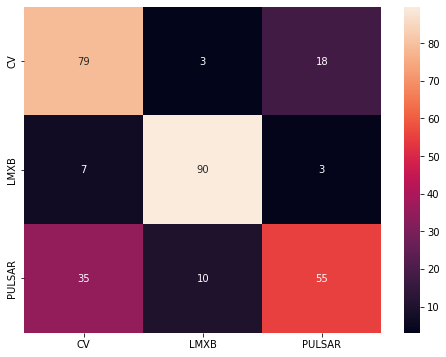

In [127]:
from sklearn.metrics import confusion_matrix
label = np.unique(y_test)
bst_clf = clf.best_iteration_
cm = confusion_matrix(y_test , clf.predict(x_test) , labels = label , normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm*100 , fmt='.0f' , annot=True , xticklabels=label, yticklabels=label)
plt.show()

## Cross validation

In [89]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
for cl , val in zip(cl_dict.keys() , cl_dict.values()):
    w = np.exp((l / val)*0.08)
    cl_weight[cl] = w
cl_weight


{'STAR': 1.2471490857110608,
 'AGN': 1.2934150067550487,
 'YSO': 1.709855972518545,
 'HMXB': 2.2803930673931028,
 'ULX': 18.4843250239435,
 'CV': 40.70969072317872,
 'LMXB': 75.5058794185036,
 'PULSAR': 439.6266860230419}

In [90]:
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
res_arr = []
from tqdm import tqdm
#for i in tqdm(range(5)):
res = simple_cv(x,y ,model=clf , k=20 , normalize_prob=0)
#res_arr.append(res)

----------------------------------------------------------
GOING for 1 / 20 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
----------------------------------------------------------
GOING for 2 / 20 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
----------------------------------------------------------
GOING for 3 / 20 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
----------------------------------------------------------
GOING for 4 / 20 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
----------------------------------------------------------
GOING for 5 / 20 

In [91]:
pd.options.display.float_format = '{:,.2f}'.format
class_scores = res['class_scores']
print(class_scores.to_markdown())

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.971608 |          0.969583 |   0.970594 |
| CV      |       0.566265 |          0.630872 |   0.596825 |
| HMXB    |       0.909091 |          0.915209 |   0.91214  |
| LMXB    |       0.79021  |          0.933884 |   0.856061 |
| PULSAR  |       0.475248 |          0.432432 |   0.45283  |
| STAR    |       0.956631 |          0.959382 |   0.958004 |
| ULX     |       0.720379 |          0.703704 |   0.711944 |
| YSO     |       0.950392 |          0.92464  |   0.937339 |


In [92]:
from utilities import take_df_mean
res_mean , res_std = take_df_mean([el['class_scores'] for el in res_arr])
res_mean

IndexError: list index out of range

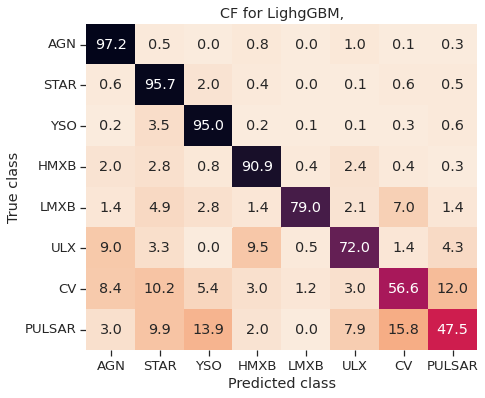

In [93]:
from utilities import plot_cf
plot_dict_def = {
    'title' : False , 
    'font_scale' : 1.2 ,
    'cbar' : False ,
    'plot_num' : 0,
}
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(7,6))
plot_cf([res['res_table']] , plot_dict=plot_dict_def , confidance=0. , ax=ax)
plt.title('CF for LighgGBM,')
plt.savefig('plots/higher_models/lgb.jpg')

In [94]:
res['res_table']

,true_class,pred_class,pred_prob
0,AGN,AGN,1.00
1,YSO,YSO,1.00
2,STAR,STAR,1.00
3,ULX,ULX,0.93
4,HMXB,HMXB,1.00
...,...,...,...
7698,AGN,AGN,1.00
7699,STAR,STAR,1.00
7700,STAR,STAR,1.00
7701,STAR,STAR,1.00


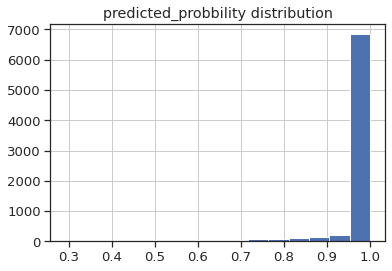

In [95]:
plt.hist(res['res_table']['pred_prob'] , bins=15)
plt.title('predicted_probbility distribution')
plt.savefig('plots/higher_models/lbg_prob.jpg')
plt.show()

### Prediction on New sources

In [96]:
from utilities import softmax , norm_prob
clf = res['clf']
pred_prob = norm_prob(clf.predict_proba(u))
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df

,class,prob,prob_margin
name,,,
2CXO J004829.5-732959,HMXB,0.66,0.40
2CXO J005449.0-725128,HMXB,0.78,0.60
2CXO J010049.1-731526,HMXB,0.78,0.61
2CXO J010049.8-731045,STAR,0.56,0.25
2CXO J010647.7-730940,STAR,0.68,0.42
...,...,...,...
2CXO J220433.1-495916,HMXB,0.94,0.91
2CXO J220508.3-495935,HMXB,0.83,0.70
2CXO J220544.0-495505,HMXB,0.88,0.81


In [97]:
u_df_th = u_df[u_df['prob']>0.9]
print(u_df_th['class'].value_counts().to_markdown())

|        |   class |
|:-------|--------:|
| AGN    |    7567 |
| STAR   |    7196 |
| YSO    |    6074 |
| HMXB   |    1551 |
| ULX    |     754 |
| CV     |     569 |
| PULSAR |     394 |
| LMXB   |     156 |


In [98]:
pd.options.display.float_format = '{:,.3f}'.format
pred_prob_df = pd.DataFrame(pred_prob , columns=[f"prob_{el}" for el in res['clf'].classes_] ,)
pred_prob_df.insert(0 , 'name' , u.index.to_list())
pred_prob_df = pred_prob_df.set_index('name')
pred_prob_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index =True)
pred_prob_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,0.661,0.399,0.003,0.006,0.661,0.000,0.004,0.262,0.065,0.000
2CXO J005449.0-725128,HMXB,0.776,0.597,0.036,0.007,0.776,0.000,0.000,0.178,0.002,0.000
2CXO J010049.1-731526,HMXB,0.781,0.607,0.010,0.004,0.781,0.000,0.005,0.173,0.026,0.000
2CXO J010049.8-731045,STAR,0.559,0.247,0.042,0.037,0.312,0.001,0.013,0.559,0.035,0.000
2CXO J010647.7-730940,STAR,0.682,0.420,0.004,0.033,0.262,0.000,0.018,0.682,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.944,0.911,0.033,0.010,0.944,0.000,0.000,0.011,0.002,0.000
2CXO J220508.3-495935,HMXB,0.830,0.704,0.036,0.126,0.830,0.000,0.002,0.002,0.003,0.000
2CXO J220544.0-495505,HMXB,0.880,0.812,0.068,0.043,0.880,0.000,0.000,0.007,0.001,0.000


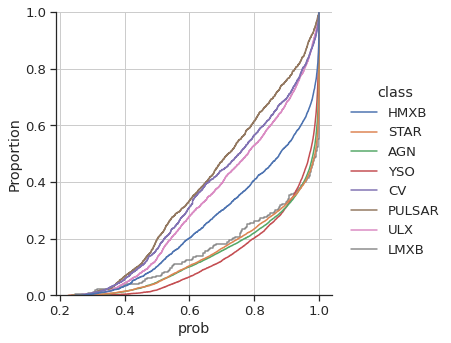

In [99]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()